<a href="https://colab.research.google.com/github/Snehlata1111/Aircraft-trajectory-prediction-internship/blob/main/aircraft_radar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [14]:
# Load and preprocess the data
# Load and preprocess the data
data = pd.read_csv('/content/aircraft (2).csv',engine='python') # Added delimiterS
data.head()

,Timestamp,Track Number,CTN,msg_hrd.source_agency,originating_node_id,time_of_track_information,lat_long_wgs84.lat,lat_long_wgs84.longitude,cartesian_pos.pos_x,cartesian_pos.pos_y,...,baro_alt_flag,baro_alt,grp_no_flag,grp_no,call_sign_flag,call_sign,element_call_sign_flag,element_call_sign,pkg_call_sign_flag,pkg_call_sign
0,1644832619864,1,EU101,9,9,35819000,22.495057,71.775152,-636325.0,1049033.0,...,0,0.0,0,NaN,0,NaN,1,2,0,NaN
1,1644832619864,2,EU100,9,9,35819000,22.486019,71.802596,-633270.0,1048027.0,...,0,0.0,0,NaN,0,NaN,1,1,0,NaN
2,1644832619864,3,EU103,9,9,35819000,22.469516,71.765430,-637407.0,1046190.0,...,0,0.0,0,NaN,0,NaN,1,4,0,NaN
3,1644832619864,4,EU102,9,9,35819000,22.460480,71.792870,-634353.0,1045184.0,...,0,0.0,0,NaN,0,NaN,1,3,0,NaN
4,1644832619864,5,EU105,9,9,35819000,22.443975,71.755712,-638489.0,1043346.0,...,0,0.0,0,NaN,0,NaN,1,6,0,NaN


In [15]:
# Encode categorical variables
acceleration_encoder = LabelEncoder()
data['acceleration'] = acceleration_encoder.fit_transform(data['acceleration'])

heading_encoder = LabelEncoder()
data['turn_direction'] = heading_encoder.fit_transform(data['turn_direction'])

movement_encoder = LabelEncoder()
data['turn_rate'] = movement_encoder.fit_transform(data['turn_rate'])

# Normalize continuous variables
continuous_cols = ['lat_long_wgs84.lat', 'lat_long_wgs84.longitude', 'cartesian_pos.pos_x', 'cartesian_pos.pos_y', 'course', 'speed']
scaler = MinMaxScaler()
data[continuous_cols] = scaler.fit_transform(data[continuous_cols])

# Split the data into input and output variables
X = data[continuous_cols]
y_acc = data['acceleration']
y_head = data['turn_direction']
y_mov = data['turn_rate']

X_train, X_test, y_train_acc, y_test_acc, y_train_head, y_test_head, y_train_mov, y_test_mov = train_test_split(X, y_acc, y_head, y_mov, test_size=0.2
                                                                                                                , random_state=42)

# Define the input sequence length
seq_len = 10  # Adjust this value based on your data

def create_sequences(X, y_acc, y_head, y_mov, seq_len):
    X_seq = []
    y_acc_seq = []
    y_head_seq = []
    y_mov_seq = []
    for i in range(len(X) - seq_len):
        X_seq.append(X.iloc[i:i+seq_len].values)
        y_acc_seq.append(y_acc.iloc[i+seq_len])
        y_head_seq.append(y_head.iloc[i+seq_len])
        y_mov_seq.append(y_mov.iloc[i+seq_len])
    return np.array(X_seq), np.array(y_acc_seq), np.array(y_head_seq), np.array(y_mov_seq)

# Create input sequences and output labels
X_train_seq, y_train_acc_seq, y_train_head_seq, y_train_mov_seq = create_sequences(X_train, y_train_acc, y_train_head, y_train_mov, seq_len)
X_test_seq, y_test_acc_seq, y_test_head_seq, y_test_mov_seq = create_sequences(X_test, y_test_acc, y_test_head, y_test_mov, seq_len)

# Convert data to PyTorch tensors
X_train_seq = torch.from_numpy(X_train_seq).float()
y_train_acc_seq = torch.from_numpy(y_train_acc_seq).long()
y_train_head_seq = torch.from_numpy(y_train_head_seq).long()
y_train_mov_seq = torch.from_numpy(y_train_mov_seq).long()

X_test_seq = torch.from_numpy(X_test_seq).float()
y_test_acc_seq = torch.from_numpy(y_test_acc_seq).long()
y_test_head_seq = torch.from_numpy(y_test_head_seq).long()
y_test_mov_seq = torch.from_numpy(y_test_mov_seq).long()

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size_acc, output_size_head, output_size_mov):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.output_layer_acc = nn.Linear(hidden_size, output_size_acc)
        self.output_layer_head = nn.Linear(hidden_size, output_size_head)
        self.output_layer_mov = nn.Linear(hidden_size, output_size_mov)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        output_acc = self.output_layer_acc(h_n.squeeze(0))
        output_head = self.output_layer_head(h_n.squeeze(0))
        output_mov = self.output_layer_mov(h_n.squeeze(0))
        return output_acc, output_head, output_mov

# Instantiate the model
input_size = X_train_seq.shape[2]
hidden_size = 64
output_size_acc = len(acceleration_encoder.classes_)
output_size_head = len(heading_encoder.classes_)
output_size_mov = len(movement_encoder.classes_)
model = LSTMModel(input_size, hidden_size, output_size_acc, output_size_head, output_size_mov)

# Define the loss function and optimizer
criterion_acc = nn.CrossEntropyLoss()
criterion_head = nn.CrossEntropyLoss()
criterion_mov = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    outputs_acc, outputs_head, outputs_mov = model(X_train_seq)

    loss_acc = criterion_acc(outputs_acc, y_train_acc_seq)
    loss_head = criterion_head(outputs_head, y_train_head_seq)
    loss_mov = criterion_mov(outputs_mov, y_train_mov_seq)

    total_loss = loss_acc + loss_head + loss_mov
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
     print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs_acc, outputs_head, outputs_mov = model(X_test_seq)

    _, predicted_acc = torch.max(outputs_acc.data, 1)
    acc_accuracy = (predicted_acc == y_test_acc_seq).sum().item() / len(y_test_acc_seq)

    _, predicted_head = torch.max(outputs_head.data, 1)
    head_accuracy = (predicted_head == y_test_head_seq).sum().item() / len(y_test_head_seq)

    _, predicted_mov = torch.max(outputs_mov.data, 1)
    mov_accuracy = (predicted_mov == y_test_mov_seq).sum().item() / len(y_test_mov_seq)

    print(f'Test Accuracy (Acceleration): {acc_accuracy:.4f}')
    print(f'Test Accuracy (Heading): {head_accuracy:.4f}')
    print(f'Test Accuracy (Movement): {mov_accuracy:.4f}')

Epoch [10/50], Loss: 0.0000
Epoch [20/50], Loss: 0.0000
Epoch [30/50], Loss: 0.0000
Epoch [40/50], Loss: 0.0000
Epoch [50/50], Loss: 0.0000
Test Accuracy (Acceleration): 1.0000
Test Accuracy (Heading): 1.0000
Test Accuracy (Movement): 1.0000


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Convert true labels and predictions to numpy arrays
y_test_acc_seq_np = y_test_acc_seq.numpy()
y_test_head_seq_np = y_test_head_seq.numpy()
y_test_mov_seq_np = y_test_mov_seq.numpy()

predicted_acc_np = predicted_acc.numpy()
predicted_head_np = predicted_head.numpy()
predicted_mov_np = predicted_mov.numpy()


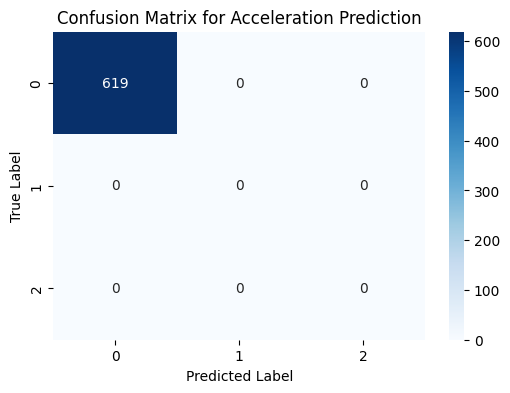

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


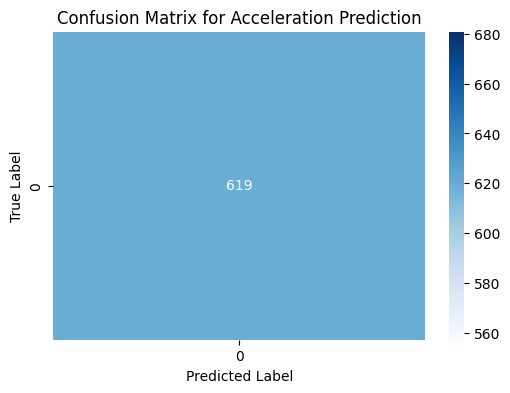

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


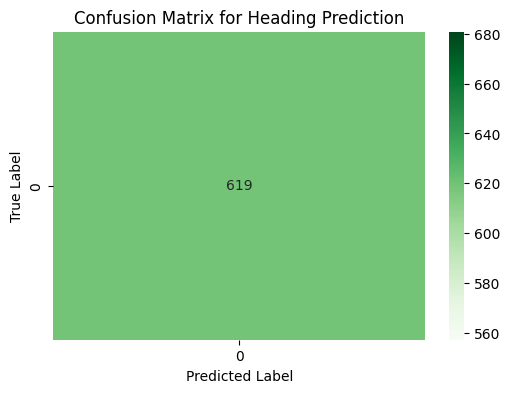

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


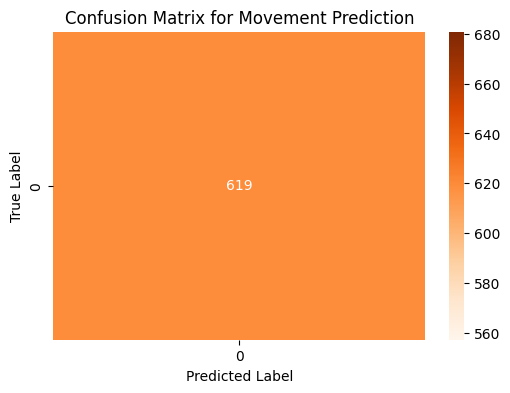

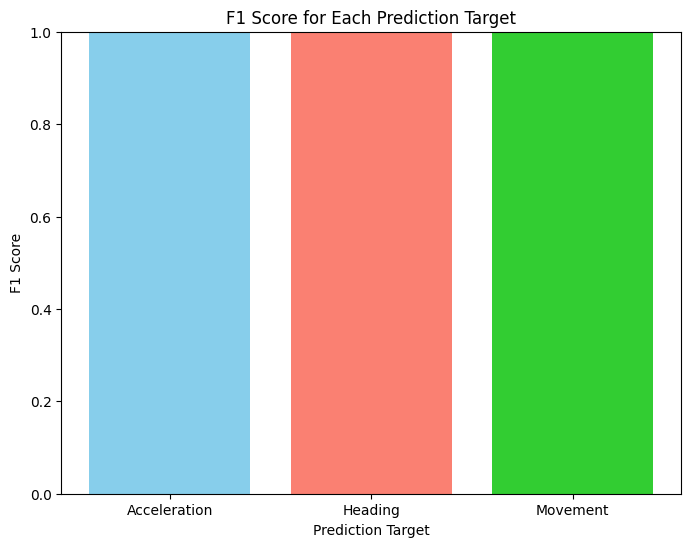

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


cm_acc = confusion_matrix(y_test_acc_seq_np, predicted_acc_np, labels=[0, 1, 2])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_acc, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Acceleration Prediction")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix for Acceleration
cm_acc = confusion_matrix(y_test_acc_seq_np, predicted_acc_np)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_acc, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Acceleration Prediction")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Confusion Matrix for Heading
cm_head = confusion_matrix(y_test_head_seq_np, predicted_head_np)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_head, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix for Heading Prediction")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Confusion Matrix for Movement
cm_mov = confusion_matrix(y_test_mov_seq_np, predicted_mov_np)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_mov, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix for Movement Prediction")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Calculate F1 Scores for each target
f1_acc = f1_score(y_test_acc_seq_np, predicted_acc_np, average='weighted')
f1_head = f1_score(y_test_head_seq_np, predicted_head_np, average='weighted')
f1_mov = f1_score(y_test_mov_seq_np, predicted_mov_np, average='weighted')

# List of F1 scores and categories
f1_scores = [f1_acc, f1_head, f1_mov]
categories = ['Acceleration', 'Heading', 'Movement']

# Plotting the F1 Scores
plt.figure(figsize=(8, 6))
plt.bar(categories, f1_scores, color=['skyblue', 'salmon', 'limegreen'])
plt.xlabel('Prediction Target')
plt.ylabel('F1 Score')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for percentage scale
plt.title('F1 Score for Each Prediction Target')
plt.show()


